# Business Case Project: Estimating Clients' Financial Needs  

Here, we will present the recommandation system for financial product that we build. We choose to implement a Need-Based recommandation system which are for us more adapted for this problem (than others systems as the collaboration filtering for example). The idea is to try to provide to the clients the best product fitted on their actual situation.  
This notebook try to answer to a classification problem thanks to machine learnig algorithms. We have a dataset whit clients informations and we we will build our system thanks to these datas.  
  
In the dataset we have a table **Needs**, with some (maybe) relevant features and two responses:  
- AccumulationInvest, which is about **Accumulation investing**, typically using dollar-cost averaging (you invest small amounts of your money at certain intervals over the course of time); the response is boolean: 1 = high propensity | 0 = low propensity;  
- AccomeInvest, which is about **Incomeinvesting**, typically through lump sum investing (one shot); the response is boolean: 1 = high propensity | 0 = low propensity.  

Then we have a second table, **Products**, with some products (funds, segregated accounts, unit-linked), their **type** (1 = Accumulation, 0 = Income), and their **risk level** (normalized in the range [0,1], usually; this is the synthetic risk and reward indicator or SRRI, for the product).  
The recommendation system is based on two key steps  
- We want to learn to recognize customers with above-average propensity to invest (AccumulationInvest = 1, and/or IncomeInvest = 1);
- For each customer we will associate a product with each need, finding the best match, based on the product type/need and its risk level, and that will be the personalized product recommendation, ie, the Next Best Action for that specific client.

# 1. Exploration of the dataset

Before talking of modeling some data, we have to know what they are about. 

We will provide some graph visualization in order to better understand what are the different behaviour of our data, how are they distributed and most importantly to have a first idea of what matter.

We also want to match with some aprioris so we will focus on some part for which our knowledge help us to pre visualize what kind of model we will need.

**What is about :** most of us don’t really understand financial and insurance products (so we don’t buy…)
But we all have real needs : 
* insurance
* payment tools and services
* saving and investment ...

We tend to buy what we need: thus, needs are a good starting point for recommending financial products and services in a personalized way

Financial needs change over time following our random life and our random lifes are not all equal. But some need can be share among different classes of people and can appear more relevant for some than others. 

So we are going  to teach an ML algo in order to first known is someone have a need, and then try to match it with different products or services.
Needs are difficult to observe and describe. We will see what kind of description we give to it in our classification problem.

<span style="color: green"> Let's first visualize data and describe our point of view ! </span>


In [1]:
# Classical libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_excel('Needs.xls', index_col=0)
dataset.head()

,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
ID,,,,,,,,,
1,60,0,2,0.228685,0.233355,68.181525,53.260067,0,1
2,78,0,2,0.358916,0.170911,21.807595,135.550048,1,0
3,33,1,2,0.317515,0.249703,23.252747,66.303678,0,1
4,69,1,4,0.767685,0.654597,166.189034,404.997689,1,1
5,58,0,3,0.429719,0.349039,21.186723,58.911930,0,0


In [3]:
dataset.describe()

,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,55.253400,0.492000,2.510600,0.419123,0.362686,62.994324,93.806264,0.383600,0.513200
std,11.971694,0.499986,0.761842,0.151383,0.151124,44.359771,105.471004,0.486311,0.499876
min,18.000000,0.000000,1.000000,0.036099,0.024790,1.537765,1.057415,0.000000,0.000000
25%,47.000000,0.000000,2.000000,0.308067,0.246444,30.596490,38.311097,0.000000,0.000000
50%,55.000000,0.000000,3.000000,0.416735,0.354526,53.399368,66.070582,0.000000,1.000000
75%,63.000000,1.000000,3.000000,0.523393,0.467125,84.122304,114.824753,1.000000,1.000000
max,97.000000,1.000000,5.000000,0.902933,0.882709,365.323385,2233.228433,1.000000,1.000000


Here, we can see a subset of our dataset. We have 7 features:
- **Age**: An interger variable which represents the clients'age
- **Gender**: An integer variable which represents the gender (Female = 1, Male = 0)
- **FamilyMembers**: Number of components of the client'family
- **FinancialEducation**: An estimation of the (normalized) level of Financial Education
- **RiskPropensity**: (Normalized) risk propensity from MIFID profile
- **Income**: The estimate client'income (in thousands of euros)
- **Wealth**: The sum of investments and cash accounts (in thousands of euros)

Then, we have our 2 targets: this is how we model needs
- **IncomeInvestment**: Boolean variable for Income investment; 1 = High propensity :   <span style="color: green"> Provides you passive income </span>
- **AccumulationInvestment**: Boolean variable for Accumulation/growth investment; 1 = High propensity : <span style="color: green"> increase in buying activity in an asset </span>
  
 
  
Now, let see some plot of the (quantitative) features, differientating the targets, to see if an hidden structure appear, or match our knowledge

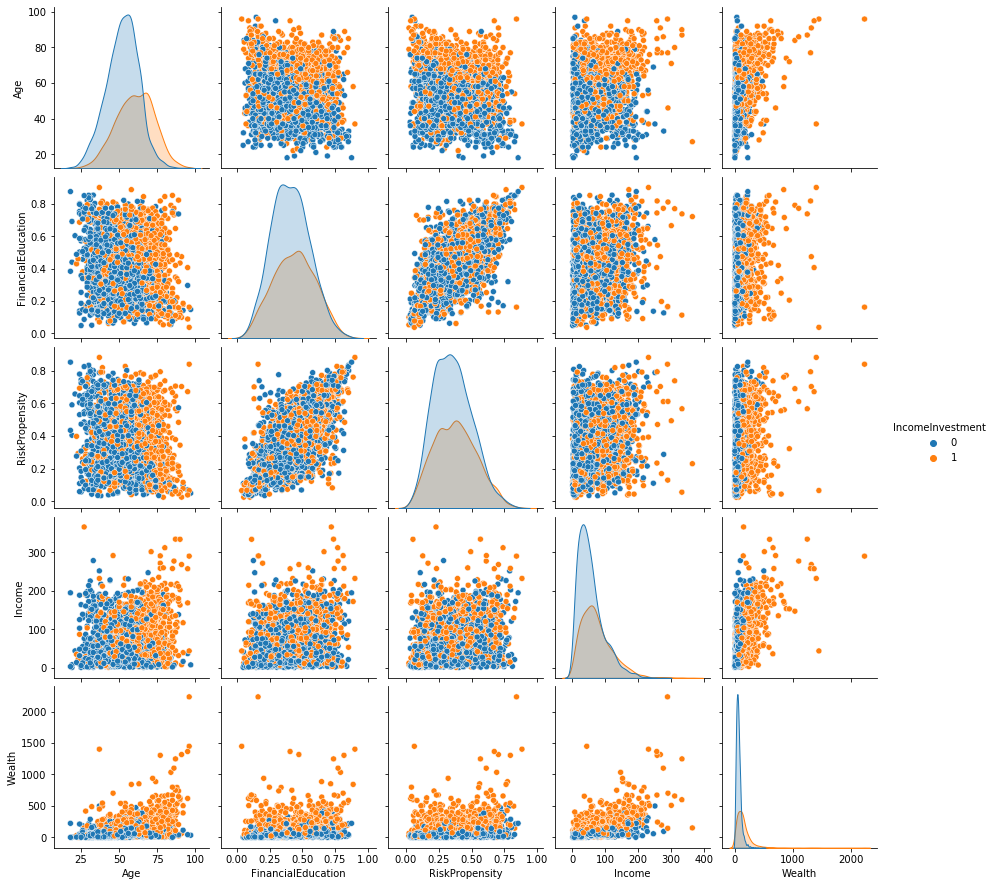

In [4]:
#Plot with the target IncomeInvestment
sns.pairplot(dataset[["IncomeInvestment", "Age", "FinancialEducation", "RiskPropensity", "Income","Wealth"]], hue='IncomeInvestment', data=dataset)

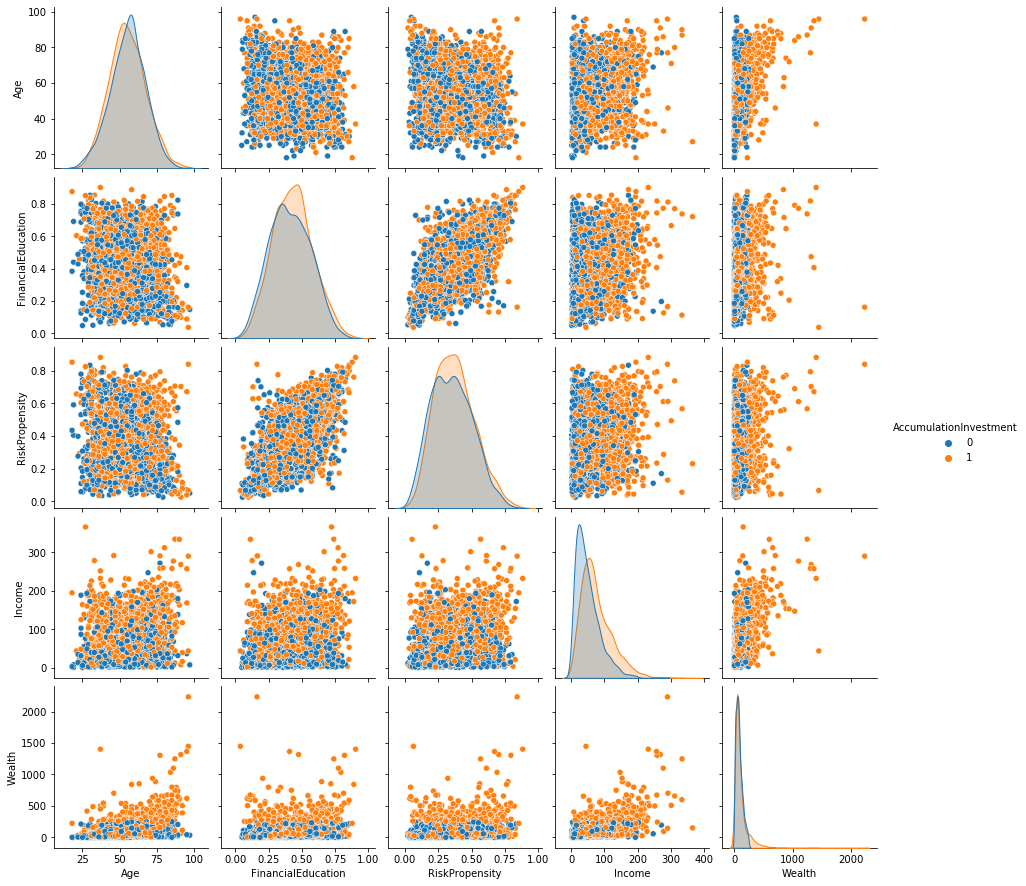

In [5]:
#Plot with the target AccumulationInvestment
sns.pairplot(dataset[["AccumulationInvestment", "Age", "FinancialEducation", "RiskPropensity", "Income","Wealth"]], hue='AccumulationInvestment', data=dataset)

**First statement :** we can see that data are not lineraly separable in any composition. In fact, the problem is already hard to express so we weren't expected to have easy separation. 

But we can state some case : wealth and income as expected seems to have an impact on clients behaviour. Since they are higth, we can imagine that need can derive from it. 

We can also observe that there is a small correlation between Financial education and RiskPropensity. This may help us to reduce the dimensionality of the problem, but we also found this two relevant for the problem so we will look at them carefully.

**Second statement :** As data exploration, we observe that Income and wealth have a particular shape : lot of data in a small length and quite in large intervalle. On a ML point of view, this can provide an algorithm to work efficiently so we are going to use a log transformation to fix this issue.


Stored 'dataset' (DataFrame)


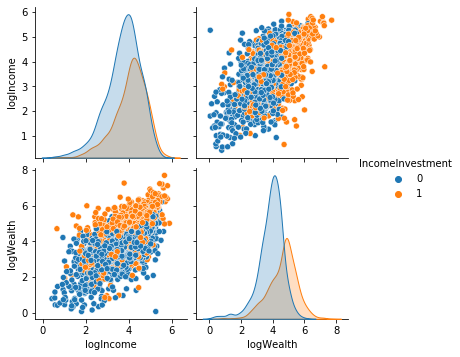

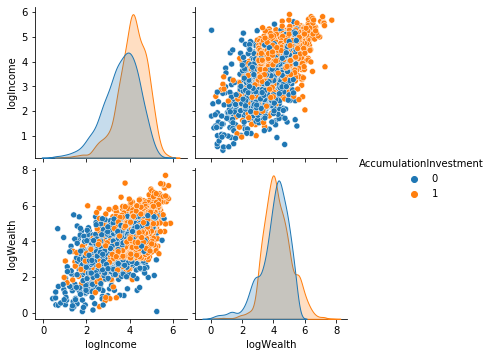

In [6]:
logIncome = np.log(dataset[["Income"]].values)
logWealth = np.log(dataset[["Wealth"]].values)

dataset["logIncome"] = logIncome
dataset["logWealth"] = logWealth
dataset = dataset.drop(["Income", "Wealth" ], axis=1)
%store dataset

sns.pairplot(dataset[["logIncome",  "logWealth", "IncomeInvestment"]], hue= "IncomeInvestment")
sns.pairplot(dataset[["logIncome",  "logWealth", "AccumulationInvestment"]], hue= "AccumulationInvestment")


They now look a bit correlated, that can be explain by the fact that greater income lead to bigger wealth.

We do it because on a Ml point of view, a model won't discriminate data that are close so it can be a problem. By doing this transforamtion, we give more chance to the model to give importance to this feature

Let's see the non continuous data, gender and family members. We don't found them really relevant in our problem since male and female doesn't change the behaviour on this kind of need, in our opinion, and family members can have an impact but we expected to have better information with the age than this. Let's see if we can have confirmation about this.

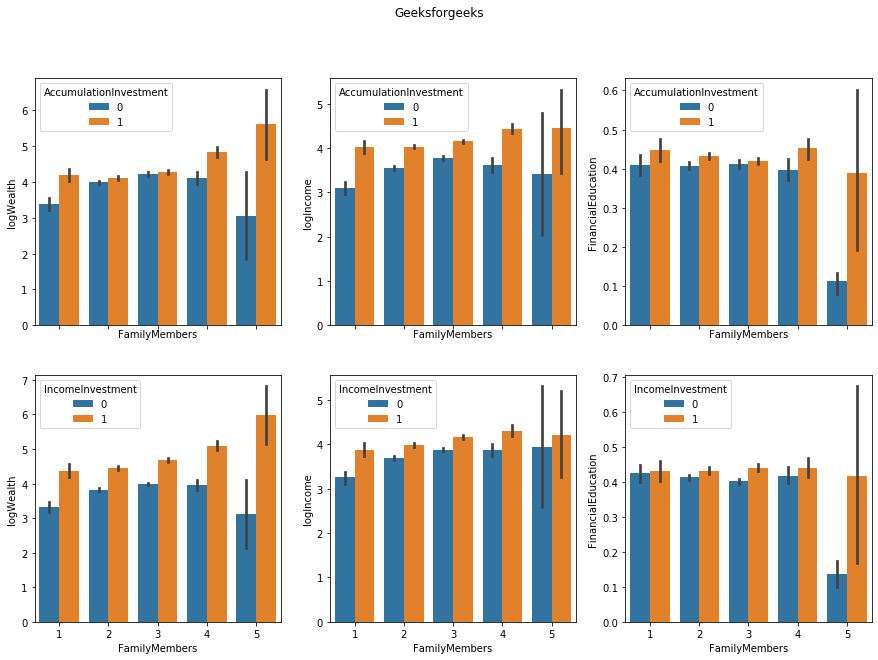

In [7]:
# we plot some distribution of them over different feature, to see the repartition
figure, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
figure.suptitle('Geeksforgeeks')

sns.barplot(x="FamilyMembers",y="logWealth", hue='AccumulationInvestment', data=dataset, ax=axes[0,0])
sns.barplot(x="FamilyMembers",y="logIncome", hue='AccumulationInvestment', data=dataset, ax=axes[0,1])
sns.barplot(x="FamilyMembers",y="FinancialEducation", hue='AccumulationInvestment', data=dataset, ax=axes[0,2])

sns.barplot(x="FamilyMembers",y="logWealth", hue='IncomeInvestment', data=dataset, ax=axes[1,0])
sns.barplot(x="FamilyMembers",y="logIncome", hue='IncomeInvestment', data=dataset, ax=axes[1,1])
sns.barplot(x="FamilyMembers",y="FinancialEducation", hue='IncomeInvestment', data=dataset, ax=axes[1,2])

**SOUS-TITRE + COMMENT**

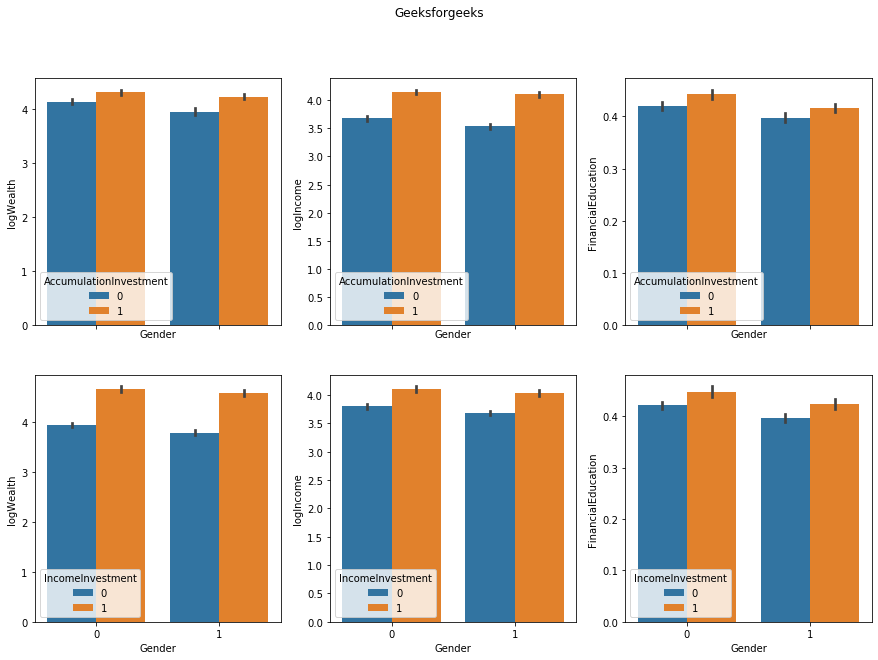

In [8]:
figure, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
figure.suptitle('Geeksforgeeks')

sns.barplot(x="Gender",y="logWealth", hue='AccumulationInvestment', data=dataset, ax=axes[0,0])
sns.barplot(x="Gender",y="logIncome", hue='AccumulationInvestment', data=dataset, ax=axes[0,1])
sns.barplot(x="Gender",y="FinancialEducation", hue='AccumulationInvestment', data=dataset, ax=axes[0,2])

sns.barplot(x="Gender",y="logWealth", hue='IncomeInvestment', data=dataset, ax=axes[1,0])
sns.barplot(x="Gender",y="logIncome", hue='IncomeInvestment', data=dataset, ax=axes[1,1])
sns.barplot(x="Gender",y="FinancialEducation", hue='IncomeInvestment', data=dataset, ax=axes[1,2])

**SOUS-TITRE + COMMENT**

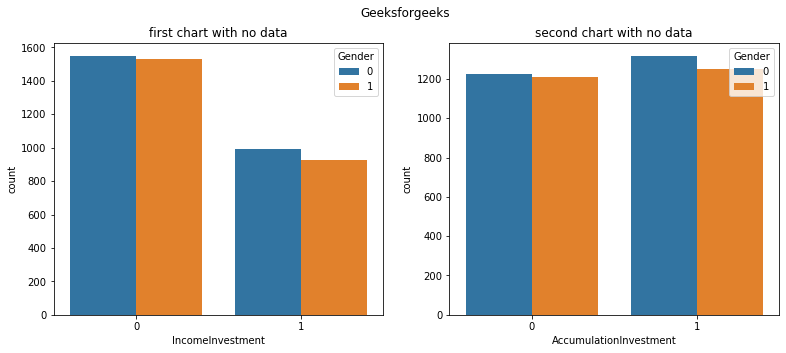

In [9]:
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(13,5))
figure.suptitle('Geeksforgeeks')
axes[0].set_title('first chart with no data')
axes[1].set_title('second chart with no data')

sns.countplot(data=dataset, x="IncomeInvestment", hue="Gender", ax=axes[0])
sns.countplot(data=dataset, x="AccumulationInvestment", hue="Gender", ax=axes[1])

**SOUS-TITRE + COMMENT**

They look well distributed with respect to our target and different feature. We can state that there is a sort of non variability in theses feature so they are less important

Here some stat to verify

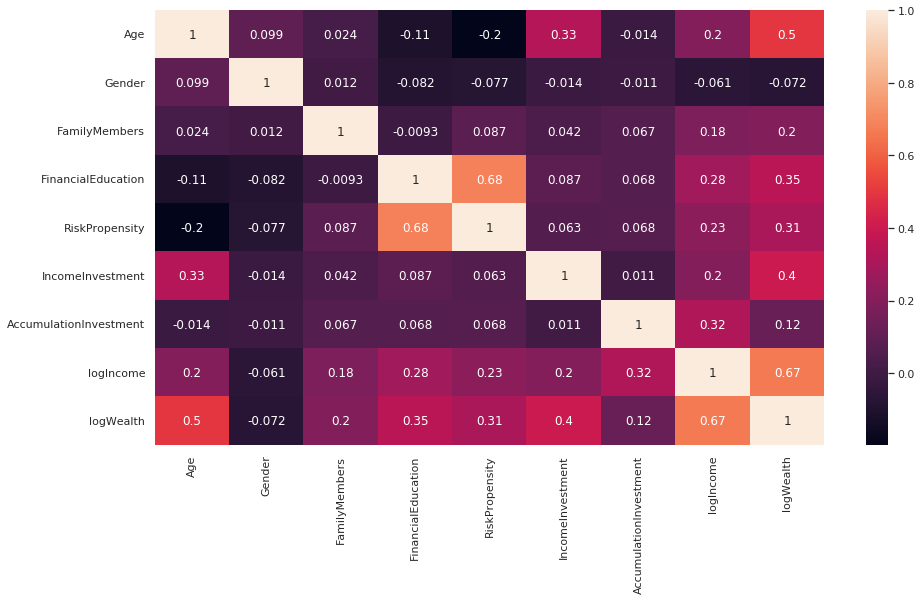

In [10]:
#Correlation matrix
corrMatrix = dataset.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

Here we plot the correlation matrix. We can see a hight positive correlation between the features *RiskPropensity* and *FinancialEducation* but also between *logIncome* and *logWealth*.  
In addition, the feature *Gender* do not have any correlation with features and targets, the target **IncomeInvestment** is sensitive to the features *Age*, *logIncome* and *logWealth* where the target **AccumulationInvestment** is sensitive to *logIncome* and *logWealth*.

In [11]:
gender_acc = dataset.groupby("AccumulationInvestment")["Gender"]
gender_inc = dataset.groupby("IncomeInvestment")["Gender"]
print("gender stats for accumulation : \n",gender_acc.describe())
print("\ngender stats for income : \n",gender_inc.describe())

family_acc = dataset.groupby("AccumulationInvestment")["FamilyMembers"]
family_inc = dataset.groupby("IncomeInvestment")["FamilyMembers"]
print("\nfamilyMembers stats for accumulation : \n",family_acc.describe())
print("\nfamilyMembers stats for income :\n",family_inc.describe())

gender stats for accumulation : 
                          count      mean       std  min  25%  50%  75%  max
AccumulationInvestment                                                     
0                       2434.0  0.497535  0.500097  0.0  0.0  0.0  1.0  1.0
1                       2566.0  0.486750  0.499922  0.0  0.0  0.0  1.0  1.0

gender stats for income : 
                    count      mean       std  min  25%  50%  75%  max
IncomeInvestment                                                     
0                 3082.0  0.497404  0.500074  0.0  0.0  0.0  1.0  1.0
1                 1918.0  0.483316  0.499852  0.0  0.0  0.0  1.0  1.0

familyMembers stats for accumulation : 
                          count      mean       std  min  25%  50%  75%  max
AccumulationInvestment                                                     
0                       2434.0  2.458505  0.757022  1.0  2.0  2.0  3.0  5.0
1                       2566.0  2.560016  0.763254  1.0  2.0  3.0  3.0  5.0

family

**Statement :** we can see that gender and family member are similarly distributed according to our target and regarding different feature that seems to be the more important. 

From a financial point of view, we do not do a difference between a man and a women. So this statement validate this thought and allow us to give less importance to the gender in the following step.

We also think that family member is link to the age. Of course it can be related to the need of the clients but from a strict financial point of view, the age seems to better explain some needs and this visualization of data showing us a pretty well distributed family member feature confirm our idea.

Statistics and visualization allow us to keep going in this way so we are satisfied

In [12]:
# freq of target in our dataset
freq_income = dataset["IncomeInvestment"].value_counts()
print(freq_income/sum(freq_income)*100)     
freq_accu = dataset["AccumulationInvestment"].value_counts()
print(freq_accu/sum(freq_accu)*100)     

0    61.64
1    38.36
Name: IncomeInvestment, dtype: float64
1    51.32
0    48.68
Name: AccumulationInvestment, dtype: float64


**MIEUX COMMENTER LES SORTIE DANS LE PRINT**

AccumulationInvestment seems to be well balance so there is no problem with this target. 
IncomeInvestment seems to be less balanced and to have more people that doesn't need this type of product. We thus have to be more precautious with this one. 

We can also said on bank point of view that we favorise giving some needs and thus propose product to client that doesn't really need it, that on contrary don't propose product to clients that need it and will purchase it for sure. This will have an impact on the metrics we will use in our ML part in the following notebook


 # <span style="color: green"> Conclusion </span>

 We have seen how our data were distributed regarding the feature in the dataset. The purpose is a classification problem in order to match clients with their needs : accumulation or income one. 

 As apriori, the features called Income, wealth and Age are the most important one. We expect to have such a importance in the different model that we will train. Even if in the visualization, there is no clear patterns.
 
 On contrary, family members and gender doesn't seems this relevant for us. We already have seems that they were uniformly distributed subject to the target and most important feature so confirming quite our idea, but hope to see this also in our model. 

 This end our data exploration. We now want to verify this with more precise metrics, doing some data prepocessing and features selection


